# Quantum Simulation of a Hybrid System
#### Ridhwan D. Iradat
This notebook simulates the dynamics of a hybrid quantum system consisting of two nitrogen-vacancy ensembles (NVEs) coupled to resonators and a transmon qubit.

In [1]:
import matplotlib.pyplot as plt
from qutip import *
import numpy as np

## System Parameters

In [2]:
# All parameters based in Wu paper but i chenge little bit, please check here.

g_a = 0.26 * 2 * np.pi  # GHz (Coupling strength TLRa-qubit)
g_b = 0.26 * 2 * np.pi  # GHz (Coupling strength TLRb-qubit)
g1 = 7 * 2 * np.pi      # MHz (Coupling strength NVE1-TLRa)
g2 = 7 * 2 * np.pi      # MHz (Coupling strength NVE2-TLRb)
omega_a = 2.8 * 2 * np.pi  # GHz (Frequency of TLRa)
omega_b = 2.8 * 2 * np.pi  # GHz (Frequency of TLRb)
omega_eg = 2.0 * 2 * np.pi  # GHz (Transition frequency qubit |g⟩ ↔ |e⟩)
omega_ge1 = 2.0 * 2 * np.pi  # GHz (Transition frequency NVE1 |g⟩ ↔ |e⟩)
omega_gu1 = 2.0 * 2 * np.pi  # GHz (Transition frequency NVE1 |g⟩ ↔ |u⟩)
omega_ge2 = 2.0 * 2 * np.pi  # GHz (Transition frequency NVE2 |g⟩ ↔ |e⟩)
omega_gu2 = 2.0 * 2 * np.pi  # GHz (Transition frequency NVE2 |g⟩ ↔ |u⟩)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Simulation time
times = np.linspace(0, 101e-9, 1000)  # 101 ns, based in Wu paper

## Operators

In [3]:
# Dimensions of each subsystem
# I can only input numbers of resonators as 2 or 3, due to the limited simulation on my laptop

resonator_levels = 2  # Energy levels of resonators
qubit_levels = 2      # Energy levels of the transmon qubit
NVE1_levels = 3       # Energy levels of NVE1
NVE2_levels = 3       # Energy levels of NVE2

# TLRs
a = tensor(destroy(resonator_levels), identity(resonator_levels), identity(qubit_levels), identity(NVE1_levels),
           identity(NVE2_levels))  # Annihilation operator for TLRa
b = tensor(identity(resonator_levels), destroy(resonator_levels), identity(qubit_levels), identity(NVE1_levels),
           identity(NVE2_levels))  # Annihilation operator for TLRb

# Transmon
sigma_plus = tensor(identity(resonator_levels), identity(resonator_levels), create(qubit_levels),
                    identity(NVE1_levels), identity(NVE2_levels))  # Raising operator for qubit
sigma_minus = tensor(identity(resonator_levels), identity(resonator_levels), destroy(qubit_levels),
                     identity(NVE1_levels), identity(NVE2_levels))  # Lowering operator for qubit

#NVE_1
S1_ge_plus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                    basis(NVE1_levels, 1) * basis(NVE1_levels, 0).dag(), identity(NVE2_levels))  # Raising operator for |g⟩ ↔ |e⟩ on NVE1
S1_ge_minus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                     basis(NVE1_levels, 0) * basis(NVE1_levels, 1).dag(), identity(NVE2_levels))  # Lowering operator for |g⟩ ↔ |e⟩ on NVE1
S1_gu_plus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                    basis(NVE1_levels, 2) * basis(NVE1_levels, 0).dag(), identity(NVE2_levels))  # Raising operator for |g⟩ ↔ |u⟩ on NVE1
S1_gu_minus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                     basis(NVE1_levels, 0) * basis(NVE1_levels, 2).dag(), identity(NVE2_levels))  # Lowering operator for |g⟩ ↔ |u⟩ on NVE1

# NVE_2
S2_ge_plus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                    identity(NVE1_levels), basis(NVE2_levels, 1) * basis(NVE2_levels, 0).dag())  # Raising operator for |g⟩ ↔ |e⟩ on NVE2
S2_ge_minus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                     identity(NVE1_levels), basis(NVE2_levels, 0) * basis(NVE2_levels, 1).dag())  # Lowering operator for |g⟩ ↔ |e⟩ on NVE2
S2_gu_plus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                    identity(NVE1_levels), basis(NVE2_levels, 2) * basis(NVE2_levels, 0).dag())  # Raising operator for |g⟩ ↔ |u⟩ on NVE2
S2_gu_minus = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                     identity(NVE1_levels), basis(NVE2_levels, 0) * basis(NVE2_levels, 2).dag())  # Lowering operator for |g⟩ ↔ |u⟩ on NVE2

### Please check all operators here

In [ ]:
#a
#a.dag()
a.dag()*a

In [ ]:
#b
#b.dag()
b.dag()*b

In [ ]:
#sigma_plus
#sigma_plus.dag()*sigma_plus
#sigma_minus
sigma_minus.dag()*sigma_minus

## Time-Dependent Coefficients
I define functions for the time-dependent coefficients in the Hamiltonian. These functions describe the external fields and detunings. The coefficients A(t) and B(t) represent Gaussian pulses applied to the resonators.

In [4]:
# Time-dependent coefficients
def H_T_coeff_a(t, args):
    return np.exp(1j * delta_a * t)

def H_T_coeff_b(t, args):
    return np.exp(1j * delta_b * t)

def H_S_coeff1_ge(t, args):
    return np.exp(1j * delta1_ge * t)

def H_S_coeff1_gu(t, args):
    return np.exp(1j * delta1_gu * t)

def H_S_coeff2_ge(t, args):
    return np.exp(1j * delta2_ge * t)

def H_S_coeff2_gu(t, args):
    return np.exp(1j * delta2_gu * t)

def H_D_coeff_a(t, args):
    A0 = 1.0  # Maximum amplitude
    t0 = 50e-9  # Pulse center (50 ns)
    sigma = 10e-9  # Pulse width (10 ns)
    return A0 * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * delta_a * t)

def H_D_coeff_b(t, args):
    B0 = 1.0  # Maximum amplitude
    t0 = 50e-9  # Pulse center (50 ns)
    sigma = 10e-9  # Pulse width (10 ns)
    return B0 * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * delta_b * t)

## Hamiltonian

### Hamiltonian of the System

The total Hamiltonian of the hybrid quantum system can be expressed as:
$$
H = H_T + H_S + H_D,
$$


#### 1. Transmon-Resonator Interaction ($ H_T $)

The interaction Hamiltonian between the resonators ($a, b$) and the transmon qubit is given by:
$$
H_T = g_a \left( a \sigma^+ e^{i\delta_a t} + a^\dagger \sigma^- e^{-i\delta_a t} \right)
+ g_b \left( b \sigma^+ e^{i\delta_b t} + b^\dagger \sigma^- e^{-i\delta_b t} \right),
$$

---

#### 2. Resonator-NVE Interaction ($ H_S $)

The interaction Hamiltonian between the resonators and the NVEs is given by:
$$
H_S = g_1 \left( a S_{1,ge}^+ e^{i\delta_{1,ge} t} + a^\dagger S_{1,gu}^- e^{-i\delta_{1,gu} t} \right)
+ g_2 \left( b S_{2,ge}^+ e^{i\delta_{2,ge} t} + b^\dagger S_{2,gu}^- e^{-i\delta_{2,gu} t} \right) + \text{h.c.},
$$

---

#### 3. External Driving Field Interaction ($ H_D $)

The interaction Hamiltonian describing the coupling of the resonators to external classical fields is given by:
$$
H_D = \left( A(t)^* a e^{i\delta_a t} + B(t)^* b e^{i\delta_b t} \right) + \text{h.c.},
$$

---


In [5]:
# Full Hamiltonian
H_t = [
    # Component HT
    [a * sigma_plus, H_T_coeff_a],  
    [a.dag() * sigma_minus, lambda t, args: np.conj(H_T_coeff_a(t, args))],  # hc
    [b * sigma_plus, H_T_coeff_b],  
    [b.dag() * sigma_minus, lambda t, args: np.conj(H_T_coeff_b(t, args))],  # hc

    # Component HS
    [a * S1_ge_plus, H_S_coeff1_ge],  
    [a.dag() * S1_ge_minus, lambda t, args: np.conj(H_S_coeff1_ge(t, args))],  # hc
    [a * S1_gu_plus, H_S_coeff1_gu],  
    [a.dag() * S1_gu_minus, lambda t, args: np.conj(H_S_coeff1_gu(t, args))],  # hc
    
    [b * S2_ge_plus, H_S_coeff2_ge],  
    [b.dag() * S2_ge_minus, lambda t, args: np.conj(H_S_coeff2_ge(t, args))],  # hc
    [b * S2_gu_plus, H_S_coeff2_gu],  
    [b.dag() * S2_gu_minus, lambda t, args: np.conj(H_S_coeff2_gu(t, args))],  # hc

    # Component HD
    [a, H_D_coeff_a],  
    [a.dag(), lambda t, args: np.conj(H_D_coeff_a(t, args))],  # hc
    [b, H_D_coeff_b],  
    [b.dag(), lambda t, args: np.conj(H_D_coeff_b(t, args))],  # hc
]

### Please check total hamiltonian here

In [ ]:
H_t

## Lindblad operators

In [6]:
# Lindblad operators, based on wu paper, please check
kappa = 1 / 20e-6  # Resonator decay rate (Hz)
gamma_q = 1 / 20e-6  # Qubit relaxation rate (Hz)
gamma_phi_q = 1 / 20e-6  # Qubit dephasing rate (Hz)

c_ops = [
    np.sqrt(kappa) * a,  # Resonator decay TLRa
    np.sqrt(kappa) * b,  # Resonator decay TLRb
    np.sqrt(gamma_q) * sigma_minus,  # Qubit relaxation
    np.sqrt(gamma_phi_q) * sigma_plus * sigma_minus,  # Qubit dephasing
]

 ## Initial State and Expectation Values

In [7]:
# Initial state, based on eq 7
psi0 = tensor(basis(resonator_levels, 0), basis(resonator_levels, 0), 
              basis(qubit_levels, 0), basis(NVE1_levels, 0), basis(NVE2_levels, 0))

# Entangled State, based on eq 10
psi_T3 = tensor(
    basis(resonator_levels, 0),  # TLRa in ground state |0⟩
    basis(resonator_levels, 0),  # TLRb in ground state |0⟩
    basis(qubit_levels, 0),      # Qubit in ground state |0⟩
    (tensor(basis(NVE1_levels, 0), basis(NVE2_levels, 0)) + 
     tensor(basis(NVE1_levels, 1), basis(NVE2_levels, 1))) / np.sqrt(2)  # Entangled state of NVE1 and NVE2
)

# Define expectation operators
e_ops = [a.dag() * a, sigma_plus.dag() * sigma_plus]

# Run simulation with expectation operators
result = mesolve(H_t, psi0, times, c_ops, e_ops)

C:\Users\ASUS\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [ ]:
psi0

In [8]:
psi_T3

Quantum object: dims=[[2, 2, 2, 3, 3], [1, 1, 1, 1, 1]], shape=(72, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.      

### Visualization of Results

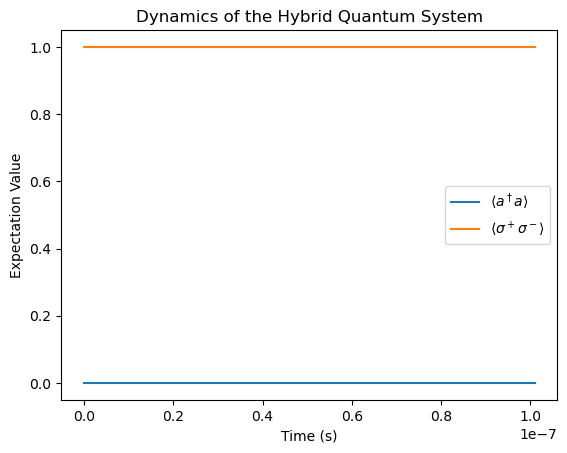

In [9]:
# Plot results
plt.plot(times, result.expect[0], label=r"$\langle a^\dagger a \rangle$")  # Photon number in TLRa
plt.plot(times, result.expect[1], label=r"$\langle \sigma^+ \sigma^- \rangle$")  # Qubit population
plt.xlabel('Time (s)')
plt.ylabel('Expectation Value')
plt.legend()
plt.title('Dynamics of the Hybrid Quantum System')
plt.show()

## Fidelity

In [10]:
result = mesolve(H_t, psi0, times, c_ops)

# Final Density matrix
rho_final = result.states[-1]

# Calculate fidelity
fidelity_value = fidelity(psi_T3, rho_final)
print(f"Fidelity: {fidelity_value}")

Fidelity: 0.7071067811865474


### Mixed State

In [19]:
# Convert to density matrix rho_T3
rho_T3 = ket2dm(psi_T3)


identity_matrix = tensor(identity(resonator_levels), identity(resonator_levels), identity(qubit_levels),
                    identity(NVE1_levels), identity(NVE2_levels)) 

# Mixing parameter lambda
lambda_param = 0.8  # Example value 

# mixed state rho_T4
rho_T4 = lambda_param * rho_T3 + ((1 - lambda_param) / 4) * identity_matrix


# Solve master equation
result = mesolve(H_t, rho_T4, times, c_ops)
rho_final_T4 = result.states[-1]  # Final density matrix

# Calculate fidelity
fidelity_value = fidelity(rho_T3, rho_final_T4)
print(f"Fidelity: {fidelity_value}")

Fidelity: 0.9223662030633055
